In [17]:
# external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# internal imports
import sys
sys.path.insert(0,'../')
from data_utils import add_deltas_and_time, scale_data, column_combinations, add_extreme, add_lifetime

# Polynomial Regression Testing

In [2]:
data_850 = pd.read_csv('../NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)
data_w_time_deltas = add_deltas_and_time(data_w_extreme)
data_w_lifetime = add_lifetime(data_w_time_deltas)

In [3]:
# get scaled provided data with deltas and time added
X = data_w_lifetime.drop(columns=['LH', 'dLH', "Extreme", "dExtreme"])
X = scale_data(X)

y = data_w_lifetime['LH']
y_extreme = data_w_lifetime['Extreme']

X.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,LifeTime
Time,,,,,,,,,,,,,,,,,,,
2000-01-01 03:00:00,-6.088163,-0.910811,0.080339,2.180997,-0.718670,-1.008888,1.243533,0.004734,-0.954545,-1.168067,0.091148,0.195511,-0.799627,-0.251402,0.394266,1.285404,-1.218041,-1.279085,-1.50
2000-01-01 06:00:00,-6.107434,-0.943091,0.476626,1.966440,-0.527986,-0.698457,1.264110,-0.049866,-0.909091,-1.168067,-0.035440,-0.160021,0.530617,-0.388836,0.580967,0.711946,0.271371,-0.790392,-1.50
2000-01-01 09:00:00,-5.950378,-1.005994,0.800095,2.043946,-0.458774,-0.685136,1.199761,-0.092620,-0.863636,-1.168067,0.483702,-0.295208,0.433411,0.098812,0.214843,0.011722,-1.105129,-0.386217,-1.50
2000-01-01 12:00:00,-5.787819,-0.943555,0.508682,2.555672,-0.569586,-0.490811,1.229895,-0.155015,-0.818182,-1.168067,0.499905,0.258125,-0.387412,0.823818,-0.327761,0.438309,0.426290,-1.056380,-1.25
2000-01-01 15:00:00,-5.531023,-0.874945,0.388518,2.123726,-0.611146,-0.452270,1.246959,-0.213574,-0.772727,-1.168067,0.777359,0.285370,-0.158807,-0.751805,-0.119031,0.071160,0.214437,-0.925509,-1.25


In [4]:
len(y_extreme[y_extreme == 1]), len(y_extreme)

(1594, 15671)

In [5]:
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=5)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]

In [6]:
len(y_extreme_under[y_extreme_under == 1]), len(y_extreme_under)

(1594, 3188)

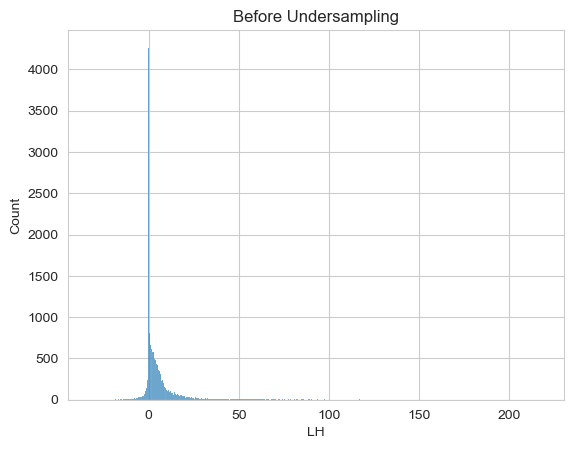

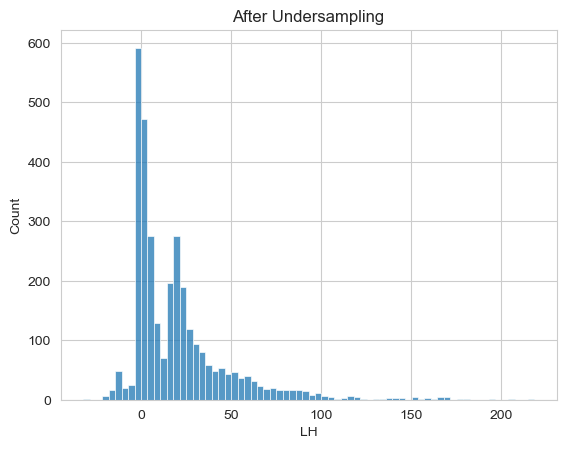

In [7]:
sns.histplot(y)
plt.title("Before Undersampling")
plt.show()
sns.histplot(y_under)
plt.title("After Undersampling")
plt.show()

In [8]:
LQ = data_850.LH.quantile(0.25)
UQ = data_850.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ)  # Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound

def classify_extremes(y_pred):
    return np.where((y_pred > upper_bound) | (y_pred < lower_bound), 1, 0)

In [9]:
preselected_features = ["AirTemp", "QV", "Omega", "VWinds"]
features_to_select = [feature for feature in X.columns if feature not in preselected_features]

features_to_select

['SeaLevPress',
 'UWinds',
 'Lat',
 'Lon',
 'PtIndex',
 'WaveTrajectory',
 'dAirTemp',
 'dQV',
 'dOmega',
 'dSeaLevPress',
 'dUWinds',
 'dVWinds',
 'dLat',
 'dLon',
 'LifeTime']

In [10]:
poly_reg = Ridge(random_state=1)  # Ridge -> L2 regularization
X_train, X_test, y_train, y_test, y_ex_train, y_ex_test = \
    train_test_split(X_under, y_under, y_extreme_under, test_size=0.2, random_state=2)

# initialize metric list
log_csv = []

# test over degrees 1-3
degrees = [1, 2, 3]
for degree in degrees:
    # test over all combinations of a maximum length
    for comb in tqdm(column_combinations(features_to_select, max_len=5), desc=f"Degree {degree}"):
        # polynomial transform train and test inputs
        features_selected = preselected_features + comb
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train[features_selected])
        X_test_poly = poly.fit_transform(X_test[features_selected])

        # fit and predict train and test
        poly_reg.fit(X_train_poly, y_train)
        y_pred_train = poly_reg.predict(X_train_poly)
        y_pred_test = poly_reg.predict(X_test_poly)

        y_pred_ex_train = classify_extremes(y_pred_train)
        y_pred_ex_test = classify_extremes(y_pred_test)

        # log training and testing metrics to list
        log_csv.append(
            [degree, features_selected,
            mean_squared_error(y_train, y_pred_train),  # train MSE
            mean_squared_error(y_test, y_pred_test),  # test MSE
            r2_score(y_train, y_pred_train),  # train r^2
            r2_score(y_test, y_pred_test),  # test r^2
            accuracy_score(y_ex_train, y_pred_ex_train),  # train accuracy
            accuracy_score(y_ex_test, y_pred_ex_test),  # test accuracy
            f1_score(y_ex_train, y_pred_ex_train),  # train f1
            f1_score(y_ex_test, y_pred_ex_test)]  # test f1
        )

Degree 1:   0%|          | 0/4943 [00:00<?, ?it/s]

Degree 2:   0%|          | 0/4943 [00:00<?, ?it/s]

Degree 3:   0%|          | 0/4943 [00:00<?, ?it/s]

In [11]:
log_csv_sorted = sorted(log_csv, key=lambda l: l[-1], reverse=True)  # sort by max testing f1
# convert to dataframe and write to file
log_df = pd.DataFrame(log_csv_sorted, columns=["degree", "feature_combination", "train_MSE",
                                               "test_MSE", "train_r^2", "test_r^2", "train_acc",
                                               "test_acc", "train_F1", "test_F1"])
log_df.to_csv("polyreg_results.csv", sep="|", index=False)

In [19]:
all_top_features = sum([log[1] for log in log_csv_sorted[:10]], start=[])
dict(Counter(all_top_features))

{'AirTemp': 10,
 'QV': 10,
 'Omega': 10,
 'VWinds': 10,
 'UWinds': 10,
 'Lat': 6,
 'PtIndex': 3,
 'dQV': 1,
 'dOmega': 8,
 'WaveTrajectory': 3,
 'dVWinds': 1,
 'LifeTime': 4,
 'Lon': 1,
 'dAirTemp': 1,
 'dLat': 1}